In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load test module for sanity check
from test_utils import test

# Logistic Regression
## Classification Using Linear Regression
Load your data.

In [2]:
from helpers import sample_data, load_data, standardize

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)] # making a feature matrix with two columns: height and weight 
y, X = sample_data(y, X, seed, size_samples=200)  # samples subset of data
x, mean_x, std_x = standardize(X)

Use `least_squares` to compute w, and visualize the results.

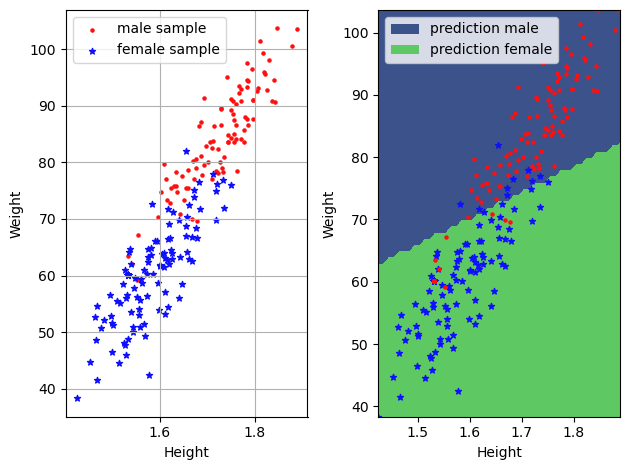

In [3]:
from least_squares import least_squares
from plots import visualization


def least_square_classification_demo(y, x):
    """Least square demo

    Args:
        y:  shape=(N, 1)
        x:  shape=(N, 2)
    """
    # classify the data by linear regression
    tx = np.c_[np.ones((y.shape[0], 1)), x] #np._c stands for "column stack", np.hstack equivalent, np.concatenate(.., axis=1) also equivalent
    
    # classify the data by linear regression
    w, mse = least_squares(y, tx)

    # visualize your classification.
    visualization(y, x, mean_x, std_x, w, "classification_by_least_square")


least_square_classification_demo(y, x)
plt.show()

#### The `least_square_classification_demo` is expected to show

![1](./classification_by_least_square.png)

## Logistic Regression

Compute your cost by negative log likelihood.

In [4]:
def sigmoid(t):
    """apply sigmoid function on t.

    Args:
        t: scalar or numpy array

    Returns:
        scalar or numpy array

    >>> sigmoid(np.array([0.1]))
    array([0.52497919])
    >>> sigmoid(np.array([0.1, 0.1]))
    array([0.52497919, 0.52497919])
    """
    return (1+np.exp(-t))**-1


test(sigmoid)

✅ Your `sigmoid` passed 2 tests.


In [5]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D) # tilde x, so includes the bias term
        w:  shape=(D, 1)

    Returns:
        a non-negative loss

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(4).reshape(2, 2)
    >>> w = np.c_[[2., 3.]]
    >>> round(calculate_loss(y, tx, w), 8)
    1.52429481
    """
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]

    N = y.shape[0]

    # y and sigmoid are multiplied element-wise -> np.sum works as intended
    #direct implementation of the loss function
    #loss = -1/N * np.sum(y * np.log(sigmoid(tx@w)) + (1 - y)*np.log(1 - sigmoid(tx@w)))
    
    # using the simplified expression 
    loss = 1/N * np.sum(np.log(1 + np.exp(tx@w)) - y * (tx@w))
    return float(loss)

test(calculate_loss)

✅ Your `calculate_loss` passed 4 tests.


In [6]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a vector of shape (D, 1)

    >>> np.set_printoptions(8)
    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> calculate_gradient(y, tx, w)
    array([[-0.10370763],
           [ 0.2067104 ],
           [ 0.51712843]])
    """
    N = y.shape[0]
    
    return 1/N * tx.T @ (sigmoid(tx@w) - y) 


test(calculate_gradient)

✅ Your `calculate_gradient` passed 5 tests.


### Using Gradient Descent
Implement your function to calculate the gradient for logistic regression.

In [7]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression. Return the loss and the updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: float

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> gamma = 0.1
    >>> loss, w = learning_by_gradient_descent(y, tx, w, gamma)
    >>> round(loss, 8)
    0.62137268
    >>> w
    array([[0.11037076],
           [0.17932896],
           [0.24828716]])
    """
    
    grad = calculate_gradient(y, tx, w)
    loss = calculate_loss(y, tx, w)
    w = w - gamma * grad
    return loss, w


test(learning_by_gradient_descent)

✅ Your `learning_by_gradient_descent` passed 7 tests.


Demo!

Current iteration=0, loss=0.6931471805599452
Current iteration=100, loss=0.25727807758229915
Current iteration=200, loss=0.2354612766230435
Current iteration=300, loss=0.2240274954664421
Current iteration=400, loss=0.217439348921451
Current iteration=500, loss=0.21337866206030554
Current iteration=600, loss=0.21074981111571242
Current iteration=700, loss=0.2089845098624057
Current iteration=800, loss=0.2077655124329582
Current iteration=900, loss=0.20690519298954654
Current iteration=1000, loss=0.20628738195411772
Current iteration=1100, loss=0.20583744941158433
Current iteration=1200, loss=0.20550598727687253
Current iteration=1300, loss=0.20525946348042884
Current iteration=1400, loss=0.2050746451887704
Current iteration=1500, loss=0.20493515330970438
Current iteration=1600, loss=0.20482926953052655
Current iteration=1700, loss=0.2047485043640546
Current iteration=1800, loss=0.20468664114263543
Current iteration=1900, loss=0.2046390853160284
Current iteration=2000, loss=0.20460241400

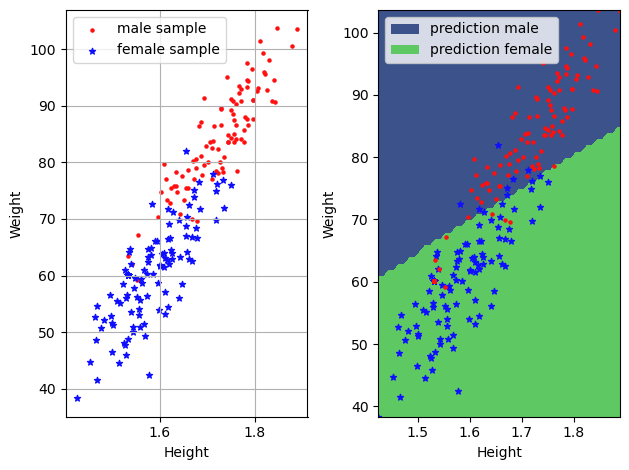

In [8]:
from helpers import de_standardize


def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.5
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_gradient_descent",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_gradient_descent_demo(y, x)
plt.show()

#### The `logistic_regression_gradient_descent_demo` is expected to show

![1](./classification_by_logistic_regression_gradient_descent.png)

Calculate your hessian below

In [9]:
def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a hessian matrix of shape=(D, D)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> calculate_hessian(y, tx, w)
    array([[0.28961235, 0.3861498 , 0.48268724],
           [0.3861498 , 0.62182124, 0.85749269],
           [0.48268724, 0.85749269, 1.23229813]])
    """
    N = y.shape[0]
    
    s = sigmoid(tx @ w) * (1 - sigmoid(tx @ w))
    S = np.diagflat(s)

    return 1/N * tx.T@S@tx

test(calculate_hessian)

✅ Your `calculate_hessian` passed 4 tests.


Write a function below to return loss, gradient, and hessian.

In [10]:
def logistic_regression(y, tx, w):
    """return the loss, gradient of the loss, and hessian of the loss.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        loss: scalar number
        gradient: shape=(D, 1)
        hessian: shape=(D, D)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> loss, gradient, hessian = logistic_regression(y, tx, w)
    >>> round(loss, 8)
    0.62137268
    >>> gradient, hessian
    (array([[-0.10370763],
           [ 0.2067104 ],
           [ 0.51712843]]), array([[0.28961235, 0.3861498 , 0.48268724],
           [0.3861498 , 0.62182124, 0.85749269],
           [0.48268724, 0.85749269, 1.23229813]]))
    """
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    return loss, gradient, hessian

test(logistic_regression)

✅ Your `logistic_regression` passed 6 tests.


### Using Newton's method
Use Newton's method for logistic regression.

In [11]:
def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step of Newton's method.
    Return the loss and updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: scalar

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> y = np.c_[[0., 0., 1., 1.]]
    >>> np.random.seed(0)
    >>> tx = np.random.rand(4, 3)
    >>> w = np.array([[0.1], [0.5], [0.5]])
    >>> gamma = 0.1
    >>> loss, w = learning_by_newton_method(y, tx, w, gamma)
    >>> round(loss, 8)
    0.71692036
    >>> w
    array([[-1.31876014],
           [ 1.0590277 ],
           [ 0.80091466]])
    """
    # return loss, gradient and Hessian: 
    loss, gradient, heassian = logistic_regression(y, tx, w)
    w_update = w - gamma * np.linalg.solve(heassian, gradient)

    # update w:
    return loss, w_update


test(learning_by_newton_method)

✅ Your `learning_by_newton_method` passed 8 tests.


demo

Current iteration=0, the loss=0.6931471805599452
Current iteration=1, the loss=0.31705776869547936
Current iteration=2, the loss=0.23652293099675295
Current iteration=3, the loss=0.20998733711242237
Current iteration=4, the loss=0.2047819931861897
Current iteration=5, the loss=0.20447559968244788
Current iteration=6, the loss=0.2044741280881354
Current iteration=7, the loss=0.20447412804945295
loss=0.20447412804945295


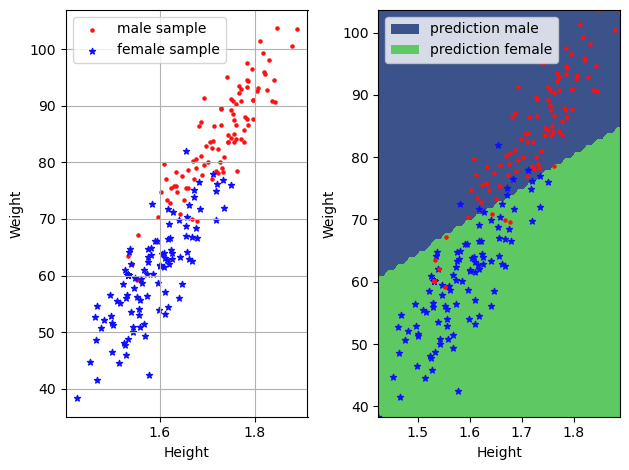

In [12]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    lambda_ = 0.1
    gamma = 1.0
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))

        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_newton_method",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_newton_method_demo(y, x)
plt.show()

#### The `logistic_regression_newton_method_demo` is expected to show

![1](./classification_by_logistic_regression_newton_method.png)

### Using penalized logistic regression
Fill in the function below.

In [13]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss and gradient.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        lambda_: scalar

    Returns:
        loss: scalar number
        gradient: shape=(D, 1)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> lambda_ = 0.1
    >>> loss, gradient = penalized_logistic_regression(y, tx, w, lambda_)
    >>> round(loss, 8)
    0.62137268
    >>> gradient
    array([[-0.08370763],
           [ 0.2467104 ],
           [ 0.57712843]])
    """
    # return loss and penalized gradient:
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w) + 2 * lambda_ * w

    return float(loss), gradient

test(penalized_logistic_regression)

✅ Your `penalized_logistic_regression` passed 7 tests.


In [14]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: scalar
        lambda_: scalar

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> np.set_printoptions(8)
    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> lambda_ = 0.1
    >>> gamma = 0.1
    >>> loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
    >>> round(loss, 8)
    0.62137268
    >>> w
    array([[0.10837076],
           [0.17532896],
           [0.24228716]])
    """
    # return loss, gradient: 
    loss, gradient = penalized_logistic_regression(y, tx, w, lambda_)
    # update w: 
    w = w - gamma * gradient

    return loss, w


test(learning_by_penalized_gradient)

✅ Your `learning_by_penalized_gradient` passed 9 tests.


Current iteration=0, loss=0.6931471805599452, norm of w=0.26301438528048887
Current iteration=100, loss=0.25727807758229915, norm of w=2.734566461450266
Current iteration=200, loss=0.2354612766230435, norm of w=3.506212872187712
Current iteration=300, loss=0.2240274954664421, norm of w=4.137248410399674
Current iteration=400, loss=0.217439348921451, norm of w=4.646877062319748
Current iteration=500, loss=0.21337866206030554, norm of w=5.0596518337402365
Current iteration=600, loss=0.21074981111571242, norm of w=5.397712151785303
Current iteration=700, loss=0.2089845098624057, norm of w=5.6778436900482445
Current iteration=800, loss=0.2077655124329582, norm of w=5.912390609869271
Current iteration=900, loss=0.20690519298954654, norm of w=6.110495618171625
Current iteration=1000, loss=0.20628738195411772, norm of w=6.279045511911447
Current iteration=1100, loss=0.20583744941158433, norm of w=6.423324206319206
Current iteration=1200, loss=0.20550598727687253, norm of w=6.547456926716369
C

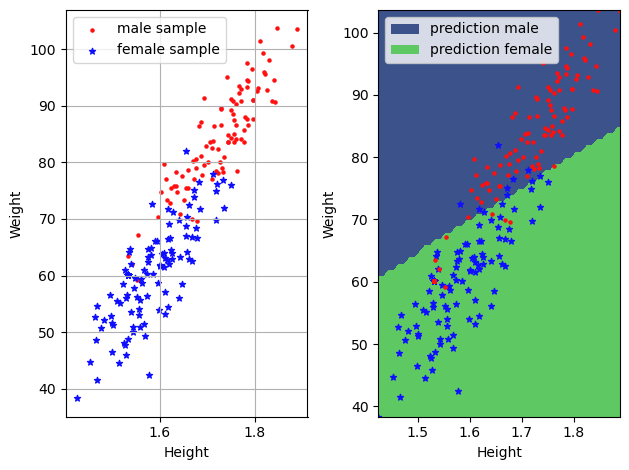

In [ ]:
def logistic_regression_penalized_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    gamma = 0.5
    lambda_ = 0.0005 #lambda_ = 0.0005
    threshold = 1e-8
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}, norm of w={n}".format(i=iter, l=loss, n=np.linalg.norm(w)))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_penalized_gradient_descent",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_penalized_gradient_descent_demo(y, x)
plt.show()

#### The `logistic_regression_penalized_gradient_descent_demo` is expected to show

![1](./classification_by_logistic_regression_penalized_gradient_descent.png)